# Imports 

In [1]:
import numpy as np
import ipynb.fs.full.PrepareData as data
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import itertools

strategyArray = []
errorArray    = [[], []]

/home/leandro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
 12%|█▏        | 5/43 [00:00<00:00, 48.79it/s]

[60, 49, 59, 59, 59, 59, 309, 309, 289, 49, 239, 269, 49]
2 chs: 60 entries
3 chs: 49 entries
4 chs: 59 entries
5 chs: 59 entries
6 chs: 59 entries
7 chs: 59 entries
8 chs: 309 entries
9 chs: 309 entries
10 chs: 289 entries
15 chs: 49 entries
20 chs: 239 entries
30 chs: 269 entries
40 chs: 49 entries


 77%|███████▋  | 33/43 [00:04<00:01,  5.06it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 95%|█████████▌| 41/43 [00:05<00:00,  7.44it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 30%|███       | 13/43 [00:00<00:01, 18.06it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 93%|█████████▎| 40/43 [00:05<00:00,  5.32it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 74%|███████▍  | 32/43 [00:05<00:02,  4.58it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 95%|█████████▌| 41/43 [00:06<00:00,  7.44it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 30%|███       | 13/43 [00:00<00:01, 19.33it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 93%|█████████▎| 40/43 [00:04<00:00,  7.31it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 43/43 [00:04<00:00,  9.86it/s]


# Sorting the dataset

In [2]:
sortedDict = {}
commonRegressors = data.commonRegressors

for regressor in commonRegressors:
    sortedDict[regressor] = 0
    
    for i in range(data.ampNumber):
        sortedDict[regressor] += data.finalList[i][regressor][0] + data.finalList[i][regressor][1]

sortedDict = dict(sorted(sortedDict.items(), key = lambda x : x[1]))
sortedDict = dict(itertools.islice(sortedDict.items(), 5))

print(sortedDict.keys())

dict_keys(['MLPRegressor', 'TransformedTargetRegressor', 'RandomForestRegressor', 'BaggingRegressor', 'ExtraTreesRegressor'])


# Processing data

In [3]:
from sklearn.metrics import mean_absolute_error

def getMAE(yTrue, yPredicted):
    gainErrors = []
    lossErrors = []
    
    rangeList = list(range(len(yTrue[0])))
    
    for true, predicted in zip(yTrue, yPredicted):
        gainTrue      = [true[x] for x in rangeList[0::2]]
        gainPredicted = [predicted[x] for x in rangeList[0::2]]
        lossTrue      = [true[x] for x in rangeList[1::2]]
        lossPredicted = [predicted[x] for x in rangeList[1::2]]
        
        gainErrors.append(mean_absolute_error(gainTrue, gainPredicted))
        lossErrors.append(mean_absolute_error(lossTrue, lossPredicted))
        
    return gainErrors, lossErrors

# Plotting function

In [4]:
import matplotlib.pyplot as plt

def plotGrid(gainData, lossData):
    fig, axis = plt.subplots(2, figsize = (10, 10))
    #fig.suptitle("One regressor per amplifier - {} amplifiers".format(data.ampNumber), fontsize = 20)
    
    axis[0].boxplot(gainData)
    axis[0].set_title("Gain test error", fontsize = 18)
    axis[0].xaxis.set_tick_params(labelsize = 14)
    axis[0].set_ylim(0, 5)
    
    axis[1].boxplot(lossData)
    axis[1].set_title("Loss test error", fontsize = 18)
    axis[1].xaxis.set_tick_params(labelsize = 14)
    axis[1].set_xticklabels(strategyArray, rotation = -45, ha = 'left')
    axis[1].set_ylim(0, 5)

    fig.text(0.08, 0.5, 'Mean Absolute error (dB)', va='center', rotation='vertical', fontsize = 18)

    plt.gcf().subplots_adjust(bottom = 0.15)
    fig.savefig("../../graphs/perAmp-{}amps.eps".format(data.ampNumber), format = 'eps', dpi = 1000, bbox_inches = "tight")

# Building the models

In [5]:
X, y = data.loadDataset()
X_train, X_test, y_train, y_test = data.train_test_split(X, y, test_size = 0.3, random_state = 0)

count = 1

In [6]:
from sklearn.neural_network import MLPRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2, 2):
    model = MultiOutputRegressor(MLPRegressor())
    
    param_grid = {
        'estimator__activation': ["identity", "logistic", "tanh", "relu"],
        'estimator__hidden_layer_sizes': [(100,), (50, 50)]
    }
    
    grid = GridSearchCV(model, param_grid=param_grid)
    grid.fit(X_train, y_train[:, i: i + 2])
    
    model = grid.best_estimator_
    model.fit(X_train, y_train[:, i: i + 2])   
    
    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 2]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 2]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - MLPRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 0.7231939395401668 +- 0.6043295653041589
Loss error: 1.1088078963618924 +- 0.7411300405023404


In [7]:
from sklearn.compose import TransformedTargetRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2, 2):
    model = MultiOutputRegressor(TransformedTargetRegressor())
    model.fit(X_train, y_train[:, i: i + 2])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 2]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 2]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - TransformedTargetRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 0.594323476155599 +- 0.6011503791693816
Loss error: 1.1142743428548176 +- 0.7330462772812684


In [8]:
from sklearn.ensemble import RandomForestRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2, 2):
    model = MultiOutputRegressor(RandomForestRegressor())
    
    param_grid = {
        'estimator__n_estimators': [50, 100, 200],
        'estimator__min_samples_split': [1, 3, 4, 5],
        'estimator__max_leaf_nodes': [None, 1, 5, 10]
    }
    
    grid = GridSearchCV(model, param_grid=param_grid)
    grid.fit(X_train, y_train[:, i: i + 2])
    
    model = grid.best_estimator_
    model.fit(X_train, y_train[:, i: i + 2])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 2]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 2]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - RandomForestRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 0.5777647006434053 +- 0.5951573083568983
Loss error: 1.1069908955601682 +- 0.7416132218581631


In [9]:
from sklearn.ensemble import BaggingRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2, 2):
    model = MultiOutputRegressor(BaggingRegressor())
    
    param_grid = {
        'estimator__n_estimators': [5, 50, 100]
    }
    
    grid = GridSearchCV(model, param_grid=param_grid)
    grid.fit(X_train, y_train[:, i: i + 2])
    
    model = grid.best_estimator_
    model.fit(X_train, y_train[:, i: i + 2])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 2]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 2]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - BaggingRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 0.5789772766837915 +- 0.5970879905632361
Loss error: 1.1039912752038392 +- 0.737713238143127


In [10]:
from sklearn.ensemble import ExtraTreesRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2, 2):
    model = MultiOutputRegressor(ExtraTreesRegressor())
    
    param_grid = {
        'estimator__n_estimators': [5, 50, 100],
        'estimator__max_features': ['auto', 'sqrt', 'log2'],
        'estimator__max_depth': [5, 50, 100]
    }
    
    grid = GridSearchCV(model, param_grid=param_grid)
    grid.fit(X_train, y_train[:, i: i + 2])
    
    model = grid.best_estimator_
    model.fit(X_train, y_train[:, i: i + 2])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 2]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 2]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - ExtraTreesRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 0.5864317382809757 +- 0.5886741614021627
Loss error: 1.121477474603917 +- 0.7203181822582402


In [11]:
from sklearn.dummy import DummyRegressor

finalY      = []
finalResult = []

for i in range(0, data.ampNumber * 2, 2):
    model = MultiOutputRegressor(DummyRegressor())
    model.fit(X_train, y_train[:, i: i + 2])

    result = model.predict(X_test)
    
    if len(finalY) == 0:
        finalY = y_test[:, i: i + 2]
        finalResult = result
    else:        
        finalY      = data.np.hstack((finalY, y_test[:, i: i + 2]))
        finalResult = data.np.hstack((finalResult, result))

strategyArray.append("{} - DummyRegressor".format(count))
result = getMAE(finalY, finalResult)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 0.9648817883895132 +- 1.0050046008188278
Loss error: 1.9205875468164795 +- 0.8182232615348035


dict_keys(['MLPRegressor', 'TransformedTargetRegressor', 'RandomForestRegressor', 'BaggingRegressor', 'ExtraTreesRegressor'])


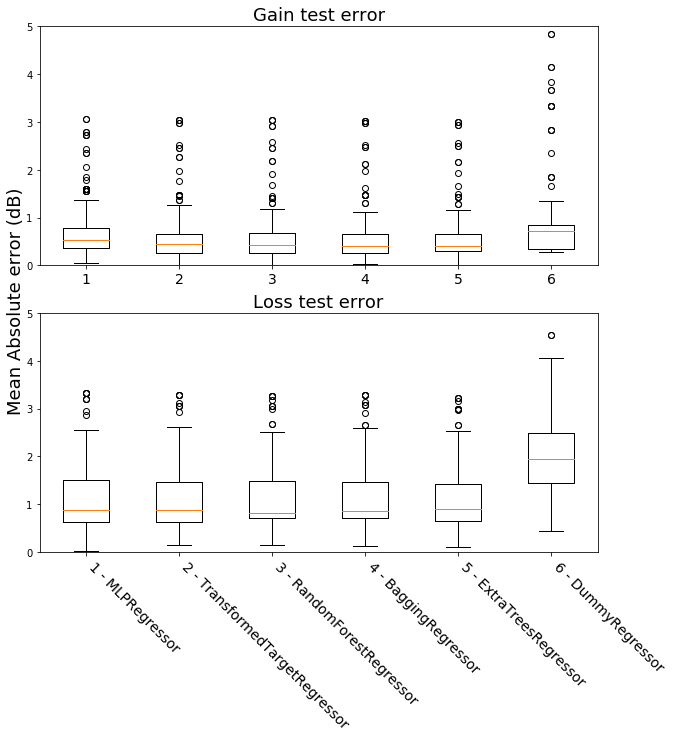

In [12]:
print(sortedDict.keys())
plotGrid(errorArray[0], errorArray[1])